In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
# Load the dataset
url = 'Mall_Customers.csv'
df = pd.read_csv(url)

# Display the first few rows of the dataframe
print(df.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [3]:
# Check for missing values
print(df.isnull().sum())

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [4]:
# Drop unnecessary columns (if any) and keep relevant ones
df = df.drop(columns=['CustomerID','Age','Gender'])  # Assuming CustomerID is not needed

# Select the features for clustering
features = df[['Annual Income (k$)', 'Spending Score (1-100)']]

In [5]:
# Detect and remove outliers using IQR method
Q1 = features.quantile(0.25)
Q3 = features.quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
filtered_features = features[~((features < (Q1 - 1.5 * IQR)) | (features > (Q3 + 1.5 * IQR))).any(axis=1)]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(filtered_features)

In [6]:
# Define a range of clusters to try
param_grid = {
    'n_clusters': list(range(2, 11)),
    'init': ['k-means++', 'random'],
    'max_iter': [300, 500, 1000],
    'n_init': [10, 20, 30],
    'random_state': [42]
}

# Perform Grid Search with Silhouette Score
best_score = -1
best_params = None

for init in param_grid['init']:
    for n_clusters in param_grid['n_clusters']:
        for max_iter in param_grid['max_iter']:
            for n_init in param_grid['n_init']:
                kmeans = KMeans(
                    n_clusters=n_clusters,
                    init=init,
                    max_iter=max_iter,
                    n_init=n_init,
                    random_state=42
                )
                cluster_labels = kmeans.fit_predict(scaled_features)
                silhouette_avg = silhouette_score(scaled_features, cluster_labels)

                if silhouette_avg > best_score:
                    best_score = silhouette_avg
                    best_params = {
                        'n_clusters': n_clusters,
                        'init': init,
                        'max_iter': max_iter,
                        'n_init': n_init
                    }

print(f'Best Silhouette Score: {best_score}')
print(f'Best Parameters: {best_params}')

Best Silhouette Score: 0.5599199830769206
Best Parameters: {'n_clusters': 5, 'init': 'k-means++', 'max_iter': 300, 'n_init': 10}


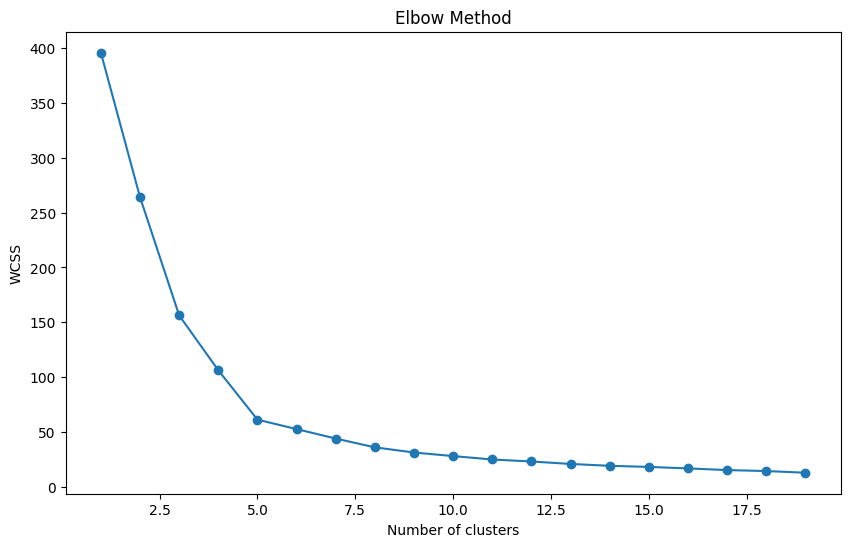

In [7]:
# Determine the optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [8]:
# Apply K-means clustering with the best parameters
kmeans_best = KMeans(
    n_clusters=9,
    init=best_params['init'],
    max_iter=best_params['max_iter'],
    n_init=best_params['n_init'],
    random_state=42
)
filtered_features['Cluster'] = kmeans_best.fit_predict(scaled_features)

# Calculate the silhouette score for the final model
silhouette_avg_best = silhouette_score(scaled_features, filtered_features['Cluster'])
print(f'Silhouette Score (Best Model): {silhouette_avg_best}')

Silhouette Score (Best Model): 0.4552996986941745


<ipython-input-8-d1bf854527c2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_features['Cluster'] = kmeans_best.fit_predict(scaled_features)


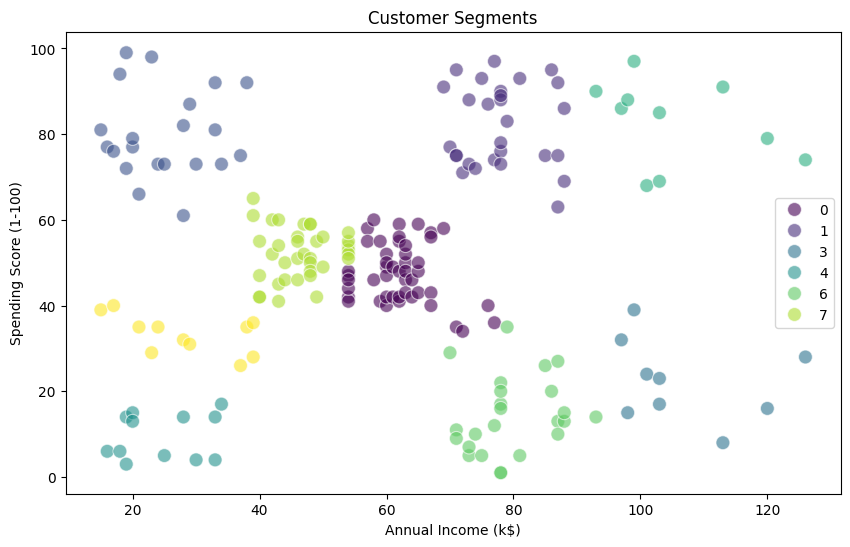

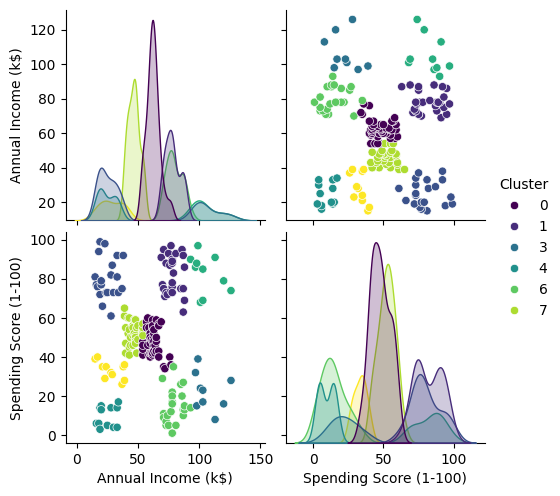

In [9]:
# Visualize the clusters (using two features for simplicity in the plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=filtered_features['Annual Income (k$)'], y=filtered_features['Spending Score (1-100)'], hue=filtered_features['Cluster'], palette='viridis', s=100, alpha=0.6, edgecolor='w')
plt.title('Customer Segments')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

# Additional pair plot to visualize clustering across all features
sns.pairplot(filtered_features, vars=['Annual Income (k$)', 'Spending Score (1-100)'], hue='Cluster', palette='viridis')
plt.show()